# Preparation

## Import Libraries

In [6]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix, average_precision_score
import seaborn as sns
import wandb

wandb.login()

True

## Connect google drive & Change directory

## Set Arguments & hyperparameters

In [7]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [8]:
from torchvision.models import vgg19


class VGG19(nn.Module):
    def __init__(self, NUM_CLS):
        super(VGG19, self).__init__()
        self.vgg = vgg19(pretrained=False)
        self.features_conv = self.vgg.features
        self.linear = nn.Sequential(
            nn.Linear(7*7*512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, NUM_CLS),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        x = self.features_conv(x)
        x = torch.flatten(x,1)
        x = self.linear(x)
        return x

In [21]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= '/USER/data'
NUM_CLS = 2

EPOCHS = 30
BATCH_SIZE = 15
LEARNING_RATE = 0.001
EARLY_STOPPING_PATIENCE = 10
INPUT_SHAPE = 224
K_FOLDS = 5

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG19(NUM_CLS).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

loss_fn = nn.BCELoss()



In [22]:
config ={
  "learning_rate": LEARNING_RATE,
  "epochs": EPOCHS,
  "batch_size": BATCH_SIZE,
  "input_shpae": INPUT_SHAPE,
  "optimizer" : optimizer,
  "loss": loss_fn
   
}
wandb.init(config = config, project="test-project", entity="team6", name="vgg-19-02") 

train_mean_loss,█████▇▅▃▂▁
train_score,▁▁▁▁▂▄▅▆██
val_mean_loss,█▇▇▇▇▅▄▂▁▁
val_score,▁▄▂▂▄▅▆▇██
train_mean_loss,0.36576
train_score,0.83101
val_mean_loss,0.35851
val_score,0.83869


# Define Dataloader

## Train & Validation Set loader

In [11]:
class ValidationDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        
        self.db = self.db[578:]
        self.db.reset_index(inplace=True)
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'augmentation.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'augmentation',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            print(os.path.join(self.data_dir,'augmentation',data['file_name']))
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID'], data['file_name']

In [12]:
class CustomDataset(Dataset):
    ####################################################################
    ####          인자값에 mode 삭제 후 idx를 추가해줘야함          ####
    ####################################################################
    def __init__(self, data_dir, idx, input_shape):
        self.data_dir = data_dir
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################
        self.idx = idx
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################
        self.db = self.db.iloc[self.idx]
        self.db.reset_index(inplace=True)
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        ####################################################################
        ####          mode를 삭제했기 때문에 이부분도 수정해줌          ####
        ####################################################################        
        print('Loading dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        ####################################################################
        ####          읽어올 label 정보 csv를 train에서 바꿔줌          ####
        ####################################################################
        db = pd.read_csv(os.path.join(self.data_dir, 'augmentation.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        ####################################################################
        ####           이미지를 읽어올 경로를 train에서 바꿔줌          ####
        ####################################################################
        cvimg = cv2.imread(os.path.join(self.data_dir,'augmentation',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        ####################################################################
        ####           리턴값에 data['file_name'] 추가해줘야함          ####
        ####################################################################
        return trans_image, data['COVID'], data['file_name']

# Define Model(VGG-16)

## Utils
### EarlyStopper

In [13]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [14]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label, _) in enumerate(dataloader):
            if batch_index % 100 == 0:
                print(f'batch_index : {batch_index}')
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        wandb.log({"train_mean_loss": self.train_mean_loss})
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        wandb.log({"train_score": self.train_score})
        msg = f'\nEpoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label, _) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        wandb.log({"val_mean_loss": self.val_mean_loss})
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        wandb.log({"val_score": self.validation_score})
        msg = f'\nEpoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [15]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load model and other utils

In [16]:
# Set optimizer, scheduler, loss function, metric function
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn

In [17]:
new_df = pd.read_csv('/USER/data/augmentation.csv')

In [18]:
train_dataset = CustomDataset(data_dir=DATA_DIR, idx=range(len(new_df)), input_shape=INPUT_SHAPE)
validation_dataset = ValidationDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

Loading dataset..
Loading dataset..


In [12]:
from sklearn.model_selection import KFold


kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)

메모리 부족으(Cuda memory out)로 실행이안됨. 첫 fold 조합에서의 최적 epoch가 5(EPOCH=6)이였으므로 실제 제출때 EPOCH=7로 두고 loss를 보고 제출할 모델을 선택하기로 결정

In [13]:
train_loss_list = [[] for _ in range(EPOCHS)]
val_loss_list = [[] for _ in range(EPOCHS)]

for fold, (train_idx, val_idx) in enumerate(kfold.split(range(578))):
    print(f'============================{fold+1}th fold============================')
    augmentations = 0
    length = len(train_idx)
    if VFLIP:
        augmentations += 1
        vflip_idx = train_idx[:length] + (578 * augmentations)
        train_idx = np.concatenate((train_idx, vflip_idx))
    if HFLIP:
        augmentations += 1
        hflip_idx = train_idx[:length] + (578 * augmentations)
        train_idx = np.concatenate((train_idx, hflip_idx))
    if ROTATE:
        augmentations += 1
        rotate_idx = train_idx[:length] + (578 * augmentations)
        train_idx = np.concatenate((train_idx, rotate_idx))
    if FLIP_ROTATE:
        augmentations += 1
        frotate_idx = train_idx[:length] + (578 * augmentations)
        train_idx = np.concatenate((train_idx, frotate_idx))

    train_dataset = CustomDataset(data_dir=DATA_DIR, idx=train_idx, input_shape=INPUT_SHAPE)
    validation_dataset = CustomDataset(data_dir=DATA_DIR, idx=val_idx, input_shape=INPUT_SHAPE)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

    model = VGG16(NUM_CLS).to(DEVICE)

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))

    # Set trainer
    trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

    for epoch_index in tqdm(range(EPOCHS)):
        trainer.train_epoch(train_dataloader, epoch_index)
        trainer.validate_epoch(validation_dataloader, epoch_index)

        train_loss = trainer.train_mean_loss
        val_loss = trainer.val_mean_loss
        
        train_loss_list[epoch_index].append(train_loss)
        val_loss_list[epoch_index].append(val_loss)

        del train_loss, val_loss
        torch.cuda.empty_cache()


============================1th fold============================


NameError: name 'VFLIP' is not defined

전체 FOLD를 순회하지 못했으므로 아래 셀은 실행안함

NameError: name 'train_loss_list' is not defined

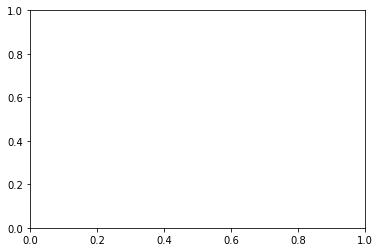

In [11]:
import matplotlib.pyplot as plt


fig, loss_ax = plt.subplots()

mean_train_loss = [np.mean(train_loss_list[i]) for i in range(EPOCHS)]
mean_val_loss = [np.mean(val_loss_list[i]) for i in range(EPOCHS)]

loss_ax.plot(mean_train_loss, 'y', label='train loss')
loss_ax.plot(mean_val_loss, 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='lower left')

plt.show()

In [27]:
np.argmin(mean_val_loss)

NameError: name 'mean_val_loss' is not defined

In [ ]:
# 
new_df = pd.read_csv('./data/augmentation.csv')

In [ ]:
train_dataset = CustomDataset(data_dir=DATA_DIR, idx=range(len(new_df)), input_shape=INPUT_SHAPE)
validation_dataset = ValidationDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

### epoch 단위 학습 진행

In [19]:

early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [23]:
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
metric_fn = get_metric_fn
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)



for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(model.state_dict(), "vgg19_aug.pt")
        early_stopper.save_model = False
    
    torch.cuda.empty_cache()

  0% 0/30 [00:00<?, ?it/s]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 0, Train loss: 0.6957692186409068, Acc: 0.5137984496124031, F1-Macro: 0.5078348548848617


  3% 1/30 [07:33<3:39:16, 453.67s/it]


Epoch 0, Val loss: 0.6956216943534937, Acc: 0.4835663014733661, F1-Macro: 0.34714603079580025
Early stopping counter 1/10
batch_index : 0
batch_index : 100
batch_index : 200

Epoch 1, Train loss: 0.6885479195652721, Acc: 0.5541085271317829, F1-Macro: 0.5447247742448256


  7% 2/30 [15:09<3:32:04, 454.44s/it]


Epoch 1, Val loss: 0.6910215223377402, Acc: 0.5746127691726483, F1-Macro: 0.470222098036539
Early stopping counter 2/10
batch_index : 0
batch_index : 100
batch_index : 200

Epoch 2, Train loss: 0.645508331951694, Acc: 0.6424806201550387, F1-Macro: 0.6410443315571982


 10% 3/30 [22:41<3:24:08, 453.65s/it]


Epoch 2, Val loss: 0.6009236057712273, Acc: 0.669059312429165, F1-Macro: 0.6624278930983518
Early stopping counter 3/10
batch_index : 0
batch_index : 100
batch_index : 200

Epoch 3, Train loss: 0.5677794611481862, Acc: 0.7187596899224806, F1-Macro: 0.7182733071814194


 13% 4/30 [30:06<3:15:27, 451.07s/it]


Epoch 3, Val loss: 0.5226285376332023, Acc: 0.7521722704948999, F1-Macro: 0.7444893471502347
Early stopping counter 4/10
batch_index : 0
batch_index : 100
batch_index : 200

Epoch 4, Train loss: 0.49024909992362853, Acc: 0.7627906976744186, F1-Macro: 0.762708563266896


 17% 5/30 [37:30<3:06:59, 448.80s/it]


Epoch 4, Val loss: 0.44516389406370843, Acc: 0.7933509633547412, F1-Macro: 0.7929533359272992
Early stopping counter 5/10
batch_index : 0
batch_index : 100
batch_index : 200

Epoch 5, Train loss: 0.4342967782552554, Acc: 0.7993798449612403, F1-Macro: 0.7991709953474603


 20% 6/30 [44:55<2:59:07, 447.81s/it]


Epoch 5, Val loss: 0.36860435528003355, Acc: 0.8458632414053646, F1-Macro: 0.844131597421071
Early stopping counter 6/10
batch_index : 0
batch_index : 100
batch_index : 200

Epoch 6, Train loss: 0.37762302087149885, Acc: 0.8412403100775194, F1-Macro: 0.840882178804026

Epoch 6, Val loss: 0.3375785815614191, Acc: 0.8791084246316585, F1-Macro: 0.8787931516070095
Validation loss decreased 0.35851187563755293 -> 0.3375785815614191


 23% 7/30 [52:27<2:52:09, 449.10s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 7, Train loss: 0.33136693875644807, Acc: 0.8576744186046512, F1-Macro: 0.8573232353656979

Epoch 7, Val loss: 0.25639583682641387, Acc: 0.9013978088401965, F1-Macro: 0.9013705564842213
Validation loss decreased 0.3375785815614191 -> 0.25639583682641387


 27% 8/30 [59:59<2:44:54, 449.77s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 8, Train loss: 0.26911427130243765, Acc: 0.8908527131782946, F1-Macro: 0.8906064979277679

Epoch 8, Val loss: 0.1942690389908173, Acc: 0.9293539856441254, F1-Macro: 0.9292893969308631
Validation loss decreased 0.25639583682641387 -> 0.1942690389908173


 30% 9/30 [1:07:30<2:37:36, 450.31s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 9, Train loss: 0.20979621282682936, Acc: 0.9119379844961241, F1-Macro: 0.9117179632305654

Epoch 9, Val loss: 0.14721004652198066, Acc: 0.944087646392142, F1-Macro: 0.9437502656296485
Validation loss decreased 0.1942690389908173 -> 0.14721004652198066


 33% 10/30 [1:15:04<2:30:28, 451.44s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 10, Train loss: 0.16581824472365536, Acc: 0.9314728682170542, F1-Macro: 0.931234185840644

Epoch 10, Val loss: 0.09515697173562578, Acc: 0.9629769550434454, F1-Macro: 0.9628745802377117
Validation loss decreased 0.14721004652198066 -> 0.09515697173562578


 37% 11/30 [1:22:34<2:22:48, 451.00s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 11, Train loss: 0.12532834065033593, Acc: 0.9510077519379845, F1-Macro: 0.9508494920873035

Epoch 11, Val loss: 0.06834130627843975, Acc: 0.9773328296184359, F1-Macro: 0.9772837796861323
Validation loss decreased 0.09515697173562578 -> 0.06834130627843975


 40% 12/30 [1:30:02<2:15:01, 450.09s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 12, Train loss: 0.08795450289084175, Acc: 0.9668217054263566, F1-Macro: 0.9667061442757867

Epoch 12, Val loss: 0.031270509485197676, Acc: 0.9913109180204005, F1-Macro: 0.9912872366840236
Validation loss decreased 0.06834130627843975 -> 0.031270509485197676


 43% 13/30 [1:37:34<2:07:41, 450.67s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 13, Train loss: 0.0635561281515973, Acc: 0.9745736434108527, F1-Macro: 0.9744822536594253

Epoch 13, Val loss: 0.026620108179486124, Acc: 0.9920664903664526, F1-Macro: 0.9920304519403436
Validation loss decreased 0.031270509485197676 -> 0.026620108179486124


 47% 14/30 [1:45:01<1:59:53, 449.57s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 14, Train loss: 0.03498920784252978, Acc: 0.9869767441860465, F1-Macro: 0.9869299348011691

Epoch 14, Val loss: 0.019890819049661248, Acc: 0.9935776350585569, F1-Macro: 0.9935510351606809
Validation loss decreased 0.026620108179486124 -> 0.019890819049661248


 50% 15/30 [1:52:29<1:52:13, 448.88s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 15, Train loss: 0.024846436328431577, Acc: 0.9928682170542635, F1-Macro: 0.9928423160537949

Epoch 15, Val loss: 0.008647405963115902, Acc: 0.9973554967888175, F1-Macro: 0.997345306318469
Validation loss decreased 0.019890819049661248 -> 0.008647405963115902


 53% 16/30 [2:00:04<1:45:13, 450.98s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 16, Train loss: 0.002300763943088828, Acc: 1.0, F1-Macro: 1.0

Epoch 16, Val loss: 0.0002387056464056317, Acc: 1.0, F1-Macro: 1.0
Validation loss decreased 0.008647405963115902 -> 0.0002387056464056317


 57% 17/30 [2:07:33<1:37:32, 450.19s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 17, Train loss: 0.0002255756453105575, Acc: 1.0, F1-Macro: 1.0

Epoch 17, Val loss: 8.60774914575641e-05, Acc: 1.0, F1-Macro: 1.0
Validation loss decreased 0.0002387056464056317 -> 8.60774914575641e-05


 60% 18/30 [2:14:59<1:29:48, 449.05s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 18, Train loss: 0.00024363926565156208, Acc: 1.0, F1-Macro: 1.0

Epoch 18, Val loss: 6.202845097869059e-05, Acc: 1.0, F1-Macro: 1.0
Validation loss decreased 8.60774914575641e-05 -> 6.202845097869059e-05


 63% 19/30 [2:22:24<1:22:04, 447.64s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 19, Train loss: 7.211581188328522e-05, Acc: 1.0, F1-Macro: 1.0

Epoch 19, Val loss: 4.002636601646065e-05, Acc: 1.0, F1-Macro: 1.0
Validation loss decreased 6.202845097869059e-05 -> 4.002636601646065e-05


 67% 20/30 [2:29:47<1:14:22, 446.27s/it]

batch_index : 0
batch_index : 100
batch_index : 200

Epoch 20, Train loss: 5.834858292371124e-05, Acc: 1.0, F1-Macro: 1.0

Epoch 20, Val loss: 3.0127045605303366e-05, Acc: 1.0, F1-Macro: 1.0
Validation loss decreased 4.002636601646065e-05 -> 3.0127045605303366e-05


 70% 21/30 [2:37:12<1:06:54, 446.07s/it]

batch_index : 0
batch_index : 100
batch_index : 200


 70% 21/30 [2:41:37<1:09:16, 461.80s/it]


KeyboardInterrupt: 

## Inference
### 모델 로드

In [28]:
TRAINED_MODEL_PATH = 'vgg19_aug.pt'

## confusion matrix

In [29]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    PR_AUC = average_precision_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [30]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH))

train_actual = []
validation_actual = []
train_pred_lst = []
validation_pred_lst = []

model.eval()
with torch.no_grad():
    for batch_index, (img, label, _) in tqdm(enumerate(train_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        train_actual += (list(label.numpy()))
        train_pred_lst.extend(pred.argmax(dim=1).tolist())

with torch.no_grad():
    for batch_index, (img, label, _) in tqdm(enumerate(validation_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        validation_actual += (list(label))
        validation_pred_lst.extend(pred.argmax(dim=1).tolist())

190it [04:12,  1.33s/it]
156it [03:21,  1.29s/it]



정확도: 1.0000
정밀도: 1.0000
재현율: 1.0000
AUC: 1.0000
F1: 1.0000


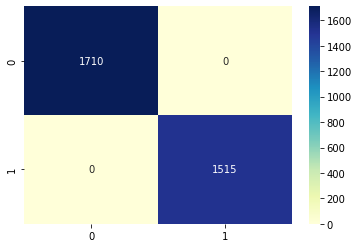

In [31]:
get_clf_eval(train_actual, train_pred_lst)


정확도: 1.0000
정밀도: 1.0000
재현율: 1.0000
AUC: 1.0000
F1: 1.0000


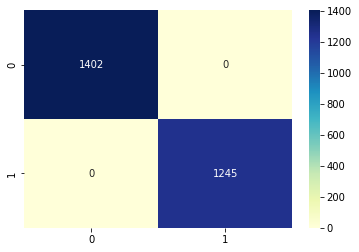

In [32]:
get_clf_eval(validation_actual, validation_pred_lst)

# Make submission

### Load dataset

In [33]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))


        ####################################################################
        ####                 리턴값에 -1 추가해줘야함                   ####
        ####################################################################
        return trans_image, -1, data['file_name']

In [34]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


## 추론 진행

In [35]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH))

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, _, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

1it [00:01,  1.57s/it]

tensor([[1.0000e+00, 6.7147e-10],
        [5.4124e-01, 4.5876e-01],
        [9.9998e-01, 2.2349e-05],
        [4.0837e-08, 1.0000e+00],
        [1.0000e+00, 6.9635e-10],
        [9.0939e-11, 1.0000e+00],
        [9.9998e-01, 1.6522e-05],
        [4.4547e-18, 1.0000e+00],
        [1.0000e+00, 2.0413e-15],
        [1.4902e-12, 1.0000e+00],
        [1.0000e+00, 5.1690e-08],
        [9.9999e-01, 4.9538e-06],
        [1.0000e+00, 4.2654e-13],
        [9.9999e-01, 1.4951e-05],
        [3.2245e-01, 6.7755e-01],
        [1.0000e+00, 1.0302e-11],
        [1.0000e+00, 1.3319e-09]], device='cuda:0')


2it [00:03,  1.54s/it]

tensor([[1.0000e+00, 1.4939e-24],
        [1.0000e+00, 2.0173e-19],
        [3.3049e-03, 9.9670e-01],
        [1.0000e+00, 5.1904e-20],
        [1.0000e+00, 1.2625e-07],
        [4.8559e-01, 5.1441e-01],
        [4.2457e-03, 9.9575e-01],
        [1.0000e+00, 6.4138e-08],
        [1.0000e+00, 2.7907e-08],
        [1.0000e+00, 9.7363e-14],
        [2.6556e-01, 7.3444e-01],
        [2.7766e-23, 1.0000e+00],
        [8.0191e-14, 1.0000e+00],
        [2.0360e-13, 1.0000e+00],
        [4.8724e-23, 1.0000e+00],
        [5.9670e-01, 4.0330e-01],
        [1.0000e+00, 1.4744e-06]], device='cuda:0')


3it [00:04,  1.50s/it]

tensor([[9.4938e-01, 5.0615e-02],
        [1.0000e+00, 9.4166e-08],
        [9.9999e-01, 1.3698e-05],
        [4.7832e-06, 1.0000e+00],
        [1.2526e-07, 1.0000e+00],
        [1.0000e+00, 7.5398e-19],
        [6.7132e-08, 1.0000e+00],
        [7.3174e-02, 9.2683e-01],
        [9.9975e-01, 2.5102e-04],
        [2.0995e-12, 1.0000e+00],
        [5.3897e-08, 1.0000e+00],
        [1.5303e-02, 9.8470e-01],
        [9.6669e-02, 9.0333e-01],
        [1.0000e+00, 9.2064e-22],
        [8.4289e-08, 1.0000e+00],
        [1.0000e+00, 2.8930e-08],
        [1.0639e-03, 9.9894e-01]], device='cuda:0')


4it [00:05,  1.44s/it]

tensor([[3.3644e-11, 1.0000e+00],
        [9.9753e-01, 2.4732e-03],
        [1.6368e-07, 1.0000e+00],
        [9.9626e-01, 3.7362e-03],
        [2.0225e-14, 1.0000e+00],
        [3.5625e-01, 6.4375e-01],
        [4.1586e-11, 1.0000e+00],
        [1.0000e+00, 3.7114e-20],
        [4.9389e-09, 1.0000e+00],
        [5.3584e-11, 1.0000e+00],
        [1.0000e+00, 1.6148e-18],
        [9.9903e-01, 9.6547e-04],
        [1.0000e+00, 2.1502e-07],
        [5.3174e-16, 1.0000e+00],
        [2.8551e-11, 1.0000e+00],
        [6.3634e-03, 9.9364e-01],
        [6.3702e-01, 3.6298e-01]], device='cuda:0')


5it [00:07,  1.39s/it]

tensor([[9.9201e-06, 9.9999e-01],
        [1.0000e+00, 7.9918e-07],
        [1.0000e+00, 2.4965e-12],
        [9.9697e-01, 3.0312e-03],
        [9.9995e-01, 5.0262e-05],
        [1.0000e+00, 6.5546e-30],
        [9.1767e-17, 1.0000e+00],
        [1.0000e+00, 3.3309e-10],
        [1.0000e+00, 2.8335e-13],
        [1.0000e+00, 6.1519e-27],
        [1.5167e-02, 9.8483e-01],
        [5.1421e-13, 1.0000e+00],
        [2.0480e-18, 1.0000e+00],
        [9.9845e-01, 1.5459e-03],
        [1.0000e+00, 9.8392e-07],
        [9.7512e-01, 2.4876e-02],
        [1.0738e-04, 9.9989e-01]], device='cuda:0')


6it [00:08,  1.35s/it]

tensor([[2.8989e-12, 1.0000e+00],
        [1.0000e+00, 3.1398e-11],
        [5.1535e-02, 9.4847e-01],
        [9.0578e-01, 9.4223e-02],
        [5.8378e-05, 9.9994e-01],
        [1.1632e-02, 9.8837e-01],
        [1.0000e+00, 1.7025e-07],
        [8.4822e-13, 1.0000e+00],
        [9.9854e-01, 1.4644e-03],
        [1.0000e+00, 5.1142e-31],
        [9.9999e-01, 7.2503e-06],
        [3.7768e-08, 1.0000e+00],
        [7.4007e-09, 1.0000e+00],
        [1.4964e-15, 1.0000e+00],
        [7.2971e-21, 1.0000e+00]], device='cuda:0')


## 결과 저장

In [36]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction(VGG19)_384.csv', index=False)